<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/AprendizajeAutomatico/TP0/TP0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Automático
# Trabajo práctico 0

- Professor: M.Sc.Saul Calderon.

- Students: 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 

- July 06th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import torch as torch
import numpy as np
import random
import math
from sympy import *

import torch.distributions as distrib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numpy import linalg as linalg

# Pandas library for reading csvs
from pandas import read_csv
import numpy as np

# Scikit binary classification algorithms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split as tts

# 1) La convolución en una dimensión (100 puntos)



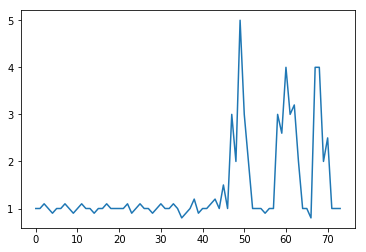

In [53]:
def oneDimensionConvolution():  
  # Exercise 1.a
  def plotSpeedSignal():
    """
    Graph the Speed Signal
    """
    # Set CSV Path
    speedDatasetPath = 'https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP0/speed.csv'
    
    # Read the dataset from csv
    speedDataset = read_csv(speedDatasetPath, header=None)
    
    # Set number of Samples and Samples Values
    numberOfSamples = speedDataset.columns.values
    speedValues = speedDataset[0:].values.tolist()[0]
    
    # Plot
    plt.plot(numberOfSamples,speedValues)
    plt.show()

    
  # Plot Speed Signal
  plotSpeedSignal()

# Test exercise 1
oneDimensionConvolution()
  
  
 

# 2) La convolución en dos dimensiones (20 puntos)

In [0]:
def plotLevelCurve(plotPoints, plotFunction1=False, plotFunction2=False):  
  # Exercise 1.a
  def plot_func1():
    """
    Graph the surface
    """
    def f_a(x,y):
      return ((np.power(x-0.7, 2))+(np.power(y-0.5, 2)))

    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)

    X, Y = np.meshgrid(x, y)
    Z = f_a(X,Y)
    
    plt.contour(X, Y, Z)
    plt.grid(True)
    plt.axis('scaled')
    
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title('Level curves of the function f(x,y) = (x-0.7)^2 + (y-0.5)^2.')
    
    plt.scatter(plotPoints[0], plotPoints[1], s=10, c='r', marker='o')
      

    plt.show()
    
  def plot_func2():
    """
    Graph the surface
    """
    def f_b(x,y):
      exp = -np.power(x, 2)-np.power(y, 2)
      return x*(np.power(2.71828, exp))

    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)

    X, Y = np.meshgrid(x, y)
    Z = f_b(X,Y)
    
    plt.contour(X, Y, Z)
    plt.grid(True)
    plt.axis('scaled')
    
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title('Level curves of the function f(x,y) = x(e)^(-x^2 - y^2)')
    
    plt.scatter(plotPoints[0], plotPoints[1], s=10, c='r', marker='o')
      

    plt.show()
    
  # Plot both functions
  if plotFunction1:
    plot_func1()
  if plotFunction2:
    plot_func2()

def funct1():
  x = Symbol('x')
  y = Symbol('y')
  return (x-0.7)**2 + (y-0.5)**2

def funct2():
  x = Symbol('x')
  y = Symbol('y')
  return x * ((N(E))**(-x**2 -y**2))

def gradient_descent(function, previousX, previousY, run=0, plotFunction1=False, plotFunction2=False, alpha = 0.1):
  x = Symbol('x')
  y = Symbol('y')
  
  # First partial derivative with respect to x
  fdx = function.diff(x)

  # First partial derivative with respect to y
  fdy = function.diff(y)
  
  # Initialize Parameters
  iterations = 0
  precision = 1/1000000
  maximumIterations = 1000
  testedPointsX = []
  testedPointsY = []
  
  # Print base values
  print('Resultado para la corrida = %d' % run)
  print('Function = %s' % function)
  print('Initial Point in X(x0) = %f' % (previousX))
  print('Initial Point in Y(y0) = %f' % (previousY))
  
  
  while True:
    gradientX = N(fdx.subs(x, previousX).subs(y, previousY)).evalf()
    gradientY = N(fdy.subs(y, previousY)).subs(x, previousX).evalf()
    currentX  = previousX - alpha * gradientX
    currentY  = previousY - alpha * gradientY
    
    # Append plot points
    testedPointsX.append(currentX)
    testedPointsY.append(currentY)

    # Stop the loop due to so many iterations
    iterations += 1
    if iterations > maximumIterations:
      print("Too many iterations\n")
      break

    if abs(currentX - previousX) <= precision and abs(currentY - previousY) <= precision:
      print('Number of iterations = %d' % (iterations))
      print('Minimum value found in X(x0) = %f' % (currentX))
      print('Minimum value found in Y(y0) = %f' % (currentY))
      if function == funct1():
        print('Correct value in X(x0) = 0.7')
        print('Correct value in Y(y0) = 0.5\n')
      if function == funct2():
        print('Correct value in X(x0) = 0.707')
        print('Correct value in Y(y0) = 0.0\n')
      
      # Plot surface 
      plotLevelCurve([testedPointsX, testedPointsY], plotFunction1, plotFunction2)
      break

    # Update x and y parameters
    previousX = currentX
    previousY = currentY
    
  
    
# Test gradient descent for Function 1
print("-----------------------------------------------")
print("Gradient Descent for Function 1")
gradient_descent(funct1(), previousX = 3, previousY = 3, run=1)
gradient_descent(funct1(), previousX = 2, previousY = 2, run=2)
gradient_descent(funct1(), previousX = 1, previousY = 1, run=3)
gradient_descent(funct1(), previousX = 0, previousY = 0, run=4)
gradient_descent(funct1(), previousX = -1, previousY = -1, run=5)
gradient_descent(funct1(), previousX = -2, previousY = -2, run=6)
gradient_descent(funct1(), previousX = -3, previousY = -3, run=7)
gradient_descent(funct1(), previousX = 1.3, previousY = 1.3, run=8)
gradient_descent(funct1(), previousX = 0.3, previousY = 0.3, run=9)
gradient_descent(funct1(), previousX = 0.4, previousY = 0.4, run=10, plotFunction1=True)

# Test gradient descent for Function 2
print("-----------------------------------------------")
print("Gradient Descent for Function 2")
gradient_descent(funct2(), previousX = 1.3, previousY = 1.3, run=1)
gradient_descent(funct2(), previousX = 2, previousY = 2, run=2)
gradient_descent(funct2(), previousX = 1, previousY = 1, run=3)
gradient_descent(funct2(), previousX = 0, previousY = 0, run=4)
gradient_descent(funct2(), previousX = -1, previousY = -1, run=5)
gradient_descent(funct2(), previousX = -2, previousY = -2, run=6)
gradient_descent(funct2(), previousX = -1.4, previousY = -1.4, run=7)
gradient_descent(funct2(), previousX = 1.3, previousY = 1.3, run=8)
gradient_descent(funct2(), previousX = 0.3, previousY = 0.3, run=9)
gradient_descent(funct2(), previousX = 0.4, previousY = 0.4, run=10, plotFunction2=True)
